In [18]:
import numpy as np
import xarray as xr
from xgcm import Grid
from matplotlib import pyplot as plt
import dask
import cmocean
from glob import glob
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

%matplotlib inline

In [39]:
files = glob('/srv/scratch/z3533156/20year_run_tide/outer_dia/outer_dia_01*.nc')
#files = glob('/scratch/fu5/cgk561/eac/20year_freerun_NEW/output_heatbudget/outer_dia_01*.nc')
# A basic chunk choice
chunks = {'ocean_time':10}

diag = xr.open_mfdataset(files, chunks=chunks)

files = glob('/srv/scratch/z3533156/20year_run_tide/outer_avg/outer_avg_01*.nc')
#files = glob('/scratch/fu5/cgk561/eac/20year_freerun_NEW/output_heatbudget/outer_avg_01*.nc')

ds = xr.open_mfdataset(files, chunks=chunks)

In [40]:
print('Total Size: %6.2F GB' % (diag.nbytes / 1e9))
print('Total Size: %6.2F GB' % (ds.nbytes / 1e9))

Total Size:  59.23 GB
Total Size: 101.53 GB


In [63]:
#check grid locations of temperature data:
ORS_temp = xr.open_dataset()

Frozen(SortedKeysDict({'ocean_time': 540, 'tracer': 2, 'boundary': 4, 's_rho': 30, 's_w': 31, 'eta_rho': 317, 'xi_rho': 272, 'eta_u': 317, 'xi_u': 271, 'eta_v': 316, 'xi_v': 272, 'eta_psi': 316, 'xi_psi': 271}))

In [1]:
ls

Barra_crossshelf_1000_transport_bar.png
Barra_crossshelf_200_transport_bar.png
crosshelf_200_transport.png
crossshelf_1000_transport_bar.png
crossshelf_2000_transport_bar.png
crossshelf_200_transport_bar.png
crossshelf_200_transport_violin.png
cross_shelf_heat_transport.ipynb
Cross_shelf_transports_Barra.ipynb
Cross_shelf_transports_NCEP.ipynb
dask-worker-space/
ROMS_SSH_EOF1_3.png
shelf_heat_1000_spatial_snapshot.png
shelf_heat_200_spatial_snapshot.png
Shelf_heat_content_le_1000.png
Shelf_heat_content_le_200.png
u_bar_mean_1000m.png
u_bar_mean_200m.png
Untitled.ipynb
xgcm_cross_shelf_transports.ipynb
Xroms_hetland_test.ipynb
X_shelf_trans1000_mean_spatial_1994_2016.png
X_shelf_trans200_mean_spatial_1994_2016.png
X_shelf_trans_anomalies_hovmoller_1000m_1994_2016.png
X_shelf_trans_anomalies_hovmoller_1000m.png
X_shelf_trans_anomalies_hovmoller.png
X_shelf_trans_hovmoller_1000m_1994_2016.png
X_shelf_trans_hovmoller_1000m.png
X_shelf_trans_hovmoller.png
X_shelf_trans_mean_1000m_1994-2016.

## Creating a grid object
While xgcm doesn't currently have an implementation for the SGRID convention for ROMS, a workaround consist on renaming eta_u and xi_v dimensions to rho. With this replacement 'psi' points have now a position (eta_v, xi_u). See issue here https://github.com/xgcm/xgcm/issues/108
Here I also test to see if the new XGCM 'metrics' functionality works.

In [42]:
# Including metrics
ds = ds.rename({'eta_u': 'eta_rho', 'xi_v': 'xi_rho', 'xi_psi': 'xi_u', 'eta_psi': 'eta_v'})

coords={'X':{'center':'xi_rho', 'inner':'xi_u'}, 
    'Y':{'center':'eta_rho', 'inner':'eta_v'}, 
    'Z':{'center':'s_rho', 'outer':'s_w'}}

grid = Grid(ds, coords=coords, periodic=[])

Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
z_rho = Zo_rho * (ds.zeta + ds.h) + ds.zeta
Zo_w = (ds.hc * ds.s_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
z_w = Zo_w * (ds.zeta + ds.h) + ds.zeta

ds.coords['z_w'] = z_w.where(ds.mask_rho, 0).transpose('ocean_time', 's_w', 'eta_rho', 'xi_rho')
ds.coords['z_rho'] = z_rho.where(ds.mask_rho, 0).transpose('ocean_time', 's_rho', 'eta_rho', 'xi_rho')


ds['pm_v'] = grid.interp(ds.pm, 'Y')
ds['pn_u'] = grid.interp(ds.pn, 'X')
ds['pm_u'] = grid.interp(ds.pm, 'X')
ds['pn_v'] = grid.interp(ds.pn, 'Y')
ds['pm_psi'] = grid.interp(grid.interp(ds.pm, 'Y'),  'X') # at psi points (eta_v, xi_u) 
ds['pn_psi'] = grid.interp(grid.interp(ds.pn, 'X'),  'Y') # at psi points (eta_v, xi_u)

ds['dx'] = 1/ds.pm
ds['dx_u'] = 1/ds.pm_u
ds['dx_v'] = 1/ds.pm_v
ds['dx_psi'] = 1/ds.pm_psi

ds['dy'] = 1/ds.pn
ds['dy_u'] = 1/ds.pn_u
ds['dy_v'] = 1/ds.pn_v
ds['dy_psi'] = 1/ds.pn_psi

ds['dz'] = grid.diff(ds.z_w, 'Z', boundary='fill')
ds['dz_w'] = grid.diff(ds.z_rho, 'Z', boundary='fill')
ds['dz_u'] = grid.interp(ds.dz, 'X')
ds['dz_w_u'] = grid.interp(ds.dz_w, 'X')
ds['dz_v'] = grid.interp(ds.dz, 'Y')
ds['dz_w_v'] = grid.interp(ds.dz_w, 'Y')

ds['dA'] = ds.dx * ds.dy

metrics = {
    ('X',): ['dx', 'dx_u', 'dx_v', 'dx_psi'], # X distances
    ('Y',): ['dy', 'dy_u', 'dy_v', 'dy_psi'], # Y distances
    ('Z',): ['dz', 'dz_u', 'dz_v', 'dz_w', 'dz_w_u', 'dz_w_v'], # Z distances
    ('X', 'Y'): ['dA'] # Areas
}
grid = Grid(ds, coords=coords, metrics=metrics, periodic=[])

### Separate out the shelf - where h is less than 200m, plot to have a look that it's reasonable 

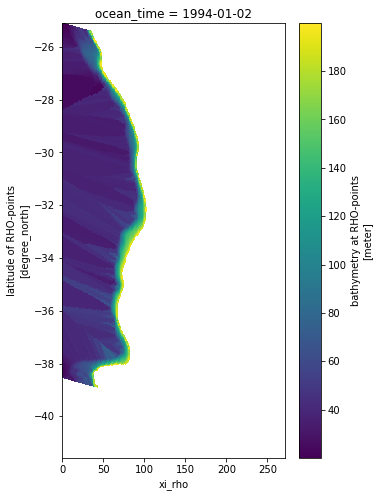

In [43]:
h_shelf = ds.h.where(ds.h<200).isel(ocean_time=0)
fig = plt.figure(figsize=(5,8))
h_shelf.plot(y='lat_rho')

## Loop through to get the index of the first NaN for each row of grid cells

In [44]:
edge = np.empty(shape=(316), dtype=int)
for x in range(0, 316):
    a = np.isnan(h_shelf[x,:]).argmax()
    edge[x]=a

## Flux Divergence
First we define a function to calculate the convergence of the advective and diffusive fluxes, since this has to be repeated for both tracers.

In [96]:
def tracer_flux_budget():
    """Calculate the convergence of fluxes of tracer. Return a new xarray.Dataset."""
    conv_horiz_adv_flux = diag.temp_hadv.rename('conv_horiz_adv_flux_TH')
    conv_horiz_diff_flux = diag.temp_hdiff.rename('conv_horiz_diff_flux_TH')
    # sign convention is opposite for vertical fluxes
    conv_vert_adv_flux = diag['temp_vadv'].rename('conv_vert_adv_flux_TH')
    conv_vert_diff_flux = diag['temp_vdiff'].rename('conv_vert_diff_flux_TH')

    all_fluxes = [conv_horiz_adv_flux, conv_horiz_diff_flux, conv_vert_adv_flux, conv_vert_diff_flux]
    conv_all_fluxes = sum(all_fluxes).rename('conv_total_flux_TH')
    
    return xr.merge(all_fluxes + [conv_all_fluxes])

In [97]:
budget_th = tracer_flux_budget()

## Add it all up
The total tendency should be given by:

In [98]:
budget_th['total_tendency_TH'] = (budget_th.conv_total_flux_TH)
budget_th

<xarray.Dataset>
Dimensions:                  (eta_rho: 317, ocean_time: 540, s_rho: 30, xi_rho: 272)
Coordinates:
  * s_rho                    (s_rho) float64 -0.9715 -0.9156 ... -0.004799
    lon_rho                  (eta_rho, xi_rho) float64 dask.array<chunksize=(317, 272), meta=np.ndarray>
    lat_rho                  (eta_rho, xi_rho) float64 dask.array<chunksize=(317, 272), meta=np.ndarray>
  * ocean_time               (ocean_time) datetime64[ns] 1994-01-02 ... 1995-...
Dimensions without coordinates: eta_rho, xi_rho
Data variables:
    conv_horiz_adv_flux_TH   (ocean_time, s_rho, eta_rho, xi_rho) float32 dask.array<chunksize=(10, 30, 317, 272), meta=np.ndarray>
    conv_horiz_diff_flux_TH  (ocean_time, s_rho, eta_rho, xi_rho) float32 dask.array<chunksize=(10, 30, 317, 272), meta=np.ndarray>
    conv_vert_adv_flux_TH    (ocean_time, s_rho, eta_rho, xi_rho) float32 dask.array<chunksize=(10, 30, 317, 272), meta=np.ndarray>
    conv_vert_diff_flux_TH   (ocean_time, s_rho, eta_rho, xi_rho) float32 dask.array<chunksize=(10, 30, 317, 272), meta=np.ndarray>
    conv_total_flux_TH       (ocean_time, s_rho, eta_rho, xi_rho) float32 dask.array<chunksize=(10, 30, 317, 272), meta=np.ndarray>
    total_tendency_TH        (ocean_time, s_rho, eta_rho, xi_rho) float32 dask.array<chunksize=(10, 30, 317, 272), meta=np.ndarray>

In [99]:
diag.temp_hadv

<xarray.DataArray 'temp_hadv' (ocean_time: 540, s_rho: 30, eta_rho: 317, xi_rho: 272)>
dask.array<concatenate, shape=(540, 30, 317, 272), dtype=float32, chunksize=(10, 30, 317, 272), chunktype=numpy.ndarray>
Coordinates:
  * s_rho       (s_rho) float64 -0.9715 -0.9156 -0.8614 ... -0.0156 -0.004799
    lon_rho     (eta_rho, xi_rho) float64 dask.array<chunksize=(317, 272), meta=np.ndarray>
    lat_rho     (eta_rho, xi_rho) float64 dask.array<chunksize=(317, 272), meta=np.ndarray>
  * ocean_time  (ocean_time) datetime64[ns] 1994-01-02 1994-01-03 ... 1995-06-25
Dimensions without coordinates: eta_rho, xi_rho
Attributes:
    long_name:  time-averaged potential temperature, horizontal advection term
    units:      Celsius second-1
    time:       ocean_time
    grid:       grid
    location:   face
    field:      temp_hadv, scalar, series

In [100]:
## Include the “truth”

In [101]:
budget_th['total_tendency_TH_truth'] = diag.temp_rate 

## Validate Budget¶
Now we do some checks to verify that the budget adds up.

## Vertical and Horizontal Integrals of Budget
We will take an average over the first 10 timesteps

In [102]:
budget_th.total_tendency_TH_truth

<xarray.DataArray 'total_tendency_TH_truth' (ocean_time: 540, s_rho: 30, eta_rho: 317, xi_rho: 272)>
dask.array<concatenate, shape=(540, 30, 317, 272), dtype=float32, chunksize=(10, 30, 317, 272), chunktype=numpy.ndarray>
Coordinates:
  * s_rho       (s_rho) float64 -0.9715 -0.9156 -0.8614 ... -0.0156 -0.004799
    lon_rho     (eta_rho, xi_rho) float64 dask.array<chunksize=(317, 272), meta=np.ndarray>
    lat_rho     (eta_rho, xi_rho) float64 dask.array<chunksize=(317, 272), meta=np.ndarray>
  * ocean_time  (ocean_time) datetime64[ns] 1994-01-02 1994-01-03 ... 1995-06-25
Dimensions without coordinates: eta_rho, xi_rho
Attributes:
    long_name:  time-averaged potential temperature, time rate of change
    units:      Celsius second-1
    time:       ocean_time
    grid:       grid
    location:   face
    field:      temp_rate, scalar, series

In [103]:
time_slice = dict(ocean_time=slice(20, 21))

In [113]:
def check_horizontal(budget, suffix):
    ds_chk = (budget[[f'total_tendency_{suffix}', f'total_tendency_{suffix}_truth']]
              .sum(dim=['s_rho', 'xi_rho']).mean(dim='ocean_time'))
    return ds_chk

def check_vertical(budget, suffix):
    ds_chk = (budget[[f'total_tendency_{suffix}', f'total_tendency_{suffix}_truth']]
              .isel(eta_rho=150, xi_rho=150))
    return ds_chk

In [114]:
th_vert = check_vertical(budget_th.isel(**time_slice), 'TH').load()
th_vert

<xarray.Dataset>
Dimensions:                  (ocean_time: 1, s_rho: 30)
Coordinates:
  * s_rho                    (s_rho) float64 -0.9715 -0.9156 ... -0.004799
    lon_rho                  float64 154.0
    lat_rho                  float64 -33.38
  * ocean_time               (ocean_time) datetime64[ns] 1994-01-22
Data variables:
    total_tendency_TH        (ocean_time, s_rho) float32 -9.798e-08 ... -3.56...
    total_tendency_TH_truth  (ocean_time, s_rho) float32 -9.798e-08 ... -3.56...

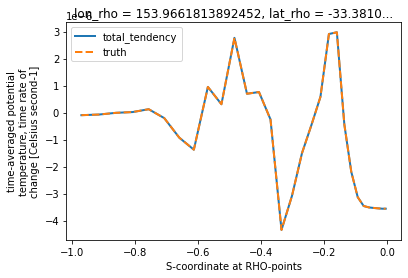

In [115]:
th_vert.total_tendency_TH.plot(linewidth=2, label = 'total_tendency')
th_vert.total_tendency_TH_truth.plot(linestyle='--', linewidth=2, label='truth')
plt.legend()

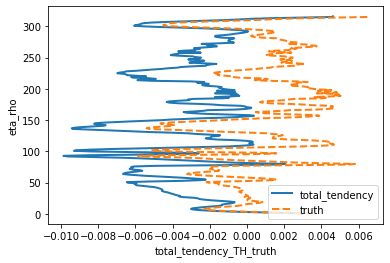

In [89]:
th_horiz = check_horizontal(budget_th.isel(**time_slice), 'TH').load()
th_horiz.total_tendency_TH.plot(linewidth=2, y='eta_rho',label='total_tendency')
th_horiz.total_tendency_TH_truth.plot(linestyle='--', linewidth=2, y='eta_rho',label='truth')
plt.legend()

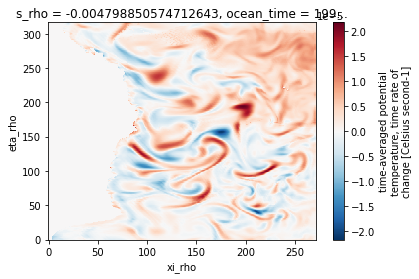

In [117]:
diag.temp_rate.isel(ocean_time=0,s_rho=-1).plot()

In [119]:
diag.temp_rate.isel(ocean_time=0,s_rho=-1, eta_rho=150,xi_rho=20).values

array(0.)

In [123]:
diag.temp_hdiff.isel(ocean_time=0,s_rho=-1, eta_rho=150,xi_rho=20).values

array(0.)